In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

random_state = 22

In [2]:
# bring in nba data set that was saved as csv
df = pd.read_csv('nba.csv')

# drop repeat season/year column
df.drop('Year', axis=1, inplace=True)

# drop name, since we already have abbreviation
df.drop('name', axis=1, inplace=True)

# convert Champion column to int with a 1 if team won championship that year, and 0 if not
df['Champion'] = df['Champion'].replace('.*', 'Yes', regex=True)
df['Champion'] = df['Champion'].fillna('No')

# create a unique id
df['uid'] = df['abbreviation'] + '_' + df['season'].astype('int').astype('str')

# drop all percentages
# df = df[df.columns.drop(list(df.filter(regex='percentage')))]

# drop rank because I want the raw stats to predict, not a predefined ranking metric
# df = df.drop('rank', axis=1)

# drop abbreviation to make my life easier
df = df.drop('abbreviation', axis=1)

# scale everything to the number of games played in the season
cols = df.columns.to_list()
do_not_scale = ['uid', 'season', 'Champion', 'games_played', 'rank'] + [col for col in cols if 'percentage' in col]
do_scale = [col for col in cols if col not in do_not_scale]
scaled_df = df[do_scale].div(df['games_played'], axis=0)
df = pd.concat([df[do_not_scale], scaled_df], axis=1)

In [3]:
df.head().T

,0,1,2,3,4
uid,SAS_1980,LAL_1980,CLE_1980,NYK_1980,BOS_1980
season,1980,1980,1980,1980,1980
Champion,No,Yes,No,No,No
games_played,82,82,82,82,82
rank,1,2,3,4,5
field_goal_percentage,0.498,0.529,0.474,0.496,0.49
free_throw_percentage,0.801,0.775,0.772,0.747,0.779
opp_field_goal_percentage,0.5,0.47,0.501,0.495,0.47
opp_free_throw_percentage,0.758,0.759,0.765,0.77,0.77
opp_three_point_field_goal_percentage,0.306,0.285,0.291,0.278,0.286


## Data Exploration

In [4]:
feature = 'opp_field_goal_percentage'

<AxesSubplot:title={'center':'opp_field_goal_percentage'}>

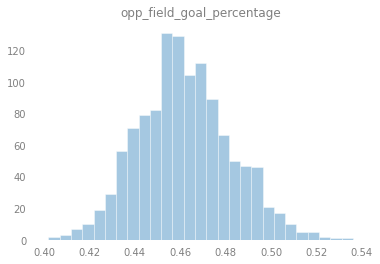

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.grid(b=None)
plt.title(feature,color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')

sns.despine(left=True,bottom=True)

sns.distplot(df[feature], kde=False, axlabel=False)

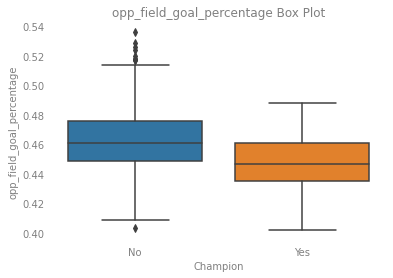

In [7]:
plt.grid(b=None)
plt.title(feature + " Box Plot",color='grey')
plt.xticks(color='grey')
plt.yticks(color='grey')
plt.xlabel("",color='grey')
plt.ylabel("",color='grey')

sns.set_style("whitegrid")
sns.despine(left=True,bottom=True)

sns.boxplot(x="Champion", y=feature, data=df);

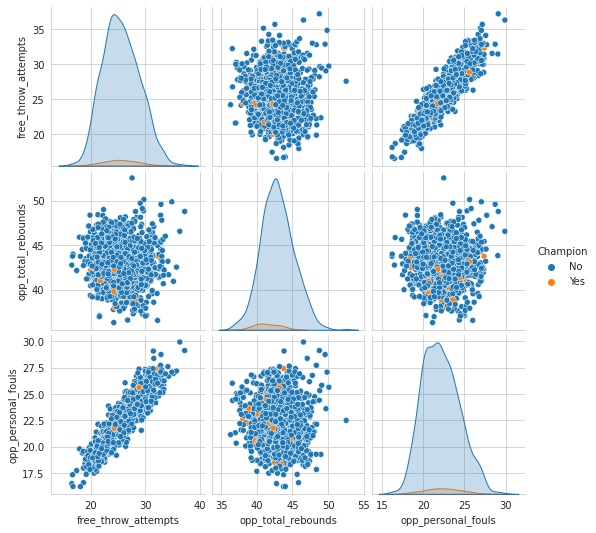

In [8]:
sns.set_style("whitegrid")
example_numeric_data = df[["free_throw_attempts", "opp_total_rebounds","opp_personal_fouls","Champion"]]  # pick a few columns
sns.pairplot(example_numeric_data, hue="Champion");

## Multicolinearity

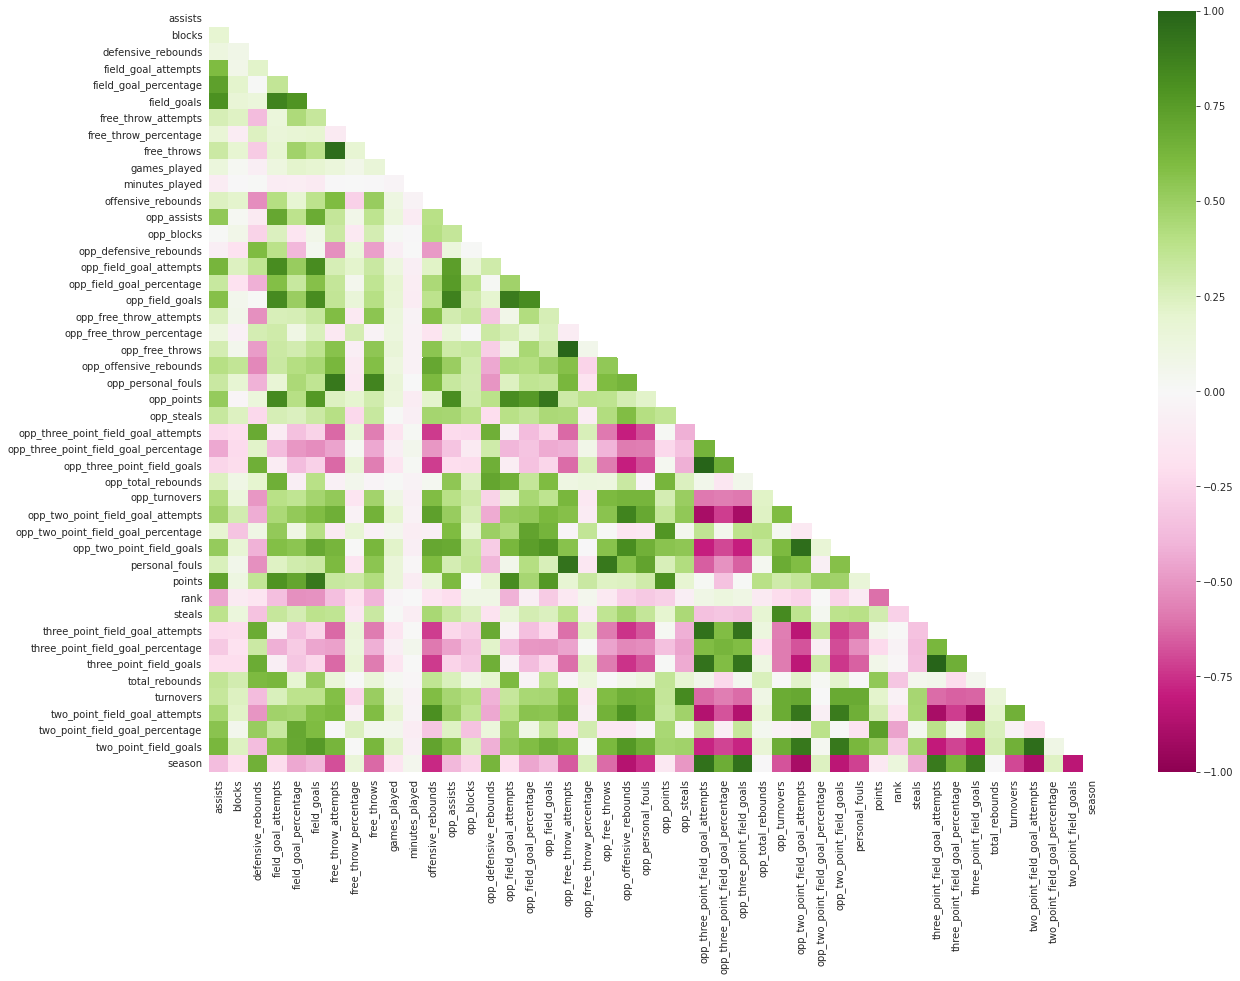

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Increase the size of the heatmap.
plt.figure(figsize=(20, 14))

# define mask to remove half of heat map, as it is just repeated information
mask = np.triu(np.ones_like(df[cols].corr(), dtype=np.bool))

heatmap = sns.heatmap(df[cols].corr(), mask=mask, vmin=-1, vmax=1, cmap="PiYG")

## Imbalanced Data

In [10]:
idcol = 'uid'  # ID column
labelcol = 'Champion'  # label column
cols = ['rank',
        'assists',
        'blocks',
        'defensive_rebounds',
        'field_goal_attempts',
#         'field_goals',
        'field_goal_percentage',
        'free_throw_attempts',
#         'free_throws',
        'free_throw_percentage',
#         'games_played',
#         'minutes_played',
        'offensive_rebounds',
        'opp_assists',
        'opp_blocks',
        'opp_defensive_rebounds',
        'opp_field_goal_attempts',
#         'opp_field_goals',
        'opp_field_goal_percentage',
        'opp_free_throw_attempts',
#         'opp_free_throws',
        'opp_free_throw_percentage',
        'opp_offensive_rebounds',
        'opp_personal_fouls',
        'opp_points',
        'opp_steals',
        'opp_three_point_field_goal_attempts',
#         'opp_three_point_field_goals',
        'opp_three_point_field_goal_percentage',
        'opp_total_rebounds',
        'opp_turnovers',
        'opp_two_point_field_goal_attempts',
#         'opp_two_point_field_goals',
        'opp_two_point_field_goal_percentage',
        'personal_fouls',
        'points',
        'steals',
        'three_point_field_goal_attempts',
#         'three_point_field_goals',
        'three_point_field_goal_percentage',
        'total_rebounds',
        'turnovers',
        'two_point_field_goal_attempts',
#         'two_point_field_goals',
        'two_point_field_goal_percentage',
        'season']

# pulling out 2022 data as that is what we'll be predicting
df_2022 = df[df['season'] == 2022]
#df_2022.to_csv('nba_2022.csv', index=False)
df = df[df['season'] < 2022]

In [11]:
# SMOTE Example
oversample = SMOTE(sampling_strategy=.25)
bal_X, bal_y = oversample.fit_resample(df[cols], df[labelcol])
bal_X['Champion'] = bal_y
bal_df = bal_X
print(df.shape)
print(bal_df.shape)

(1164, 48)
(1402, 37)


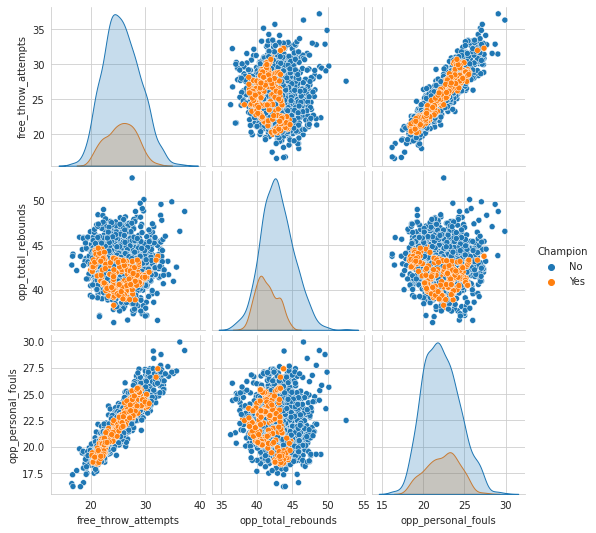

In [12]:
sns.set_style("whitegrid")
example_numeric_data = bal_df[["free_throw_attempts", "opp_total_rebounds","opp_personal_fouls","Champion"]]  # pick a few columns
sns.pairplot(example_numeric_data, hue="Champion");

## Split Data

In [13]:
df_train, df_test = train_test_split(df, test_size=.2, random_state=random_state)
X_train = df_train[cols]
y_train = df_train[labelcol]
X_test = df_test[cols]
y_test = df_test[labelcol]

## Random Forest Classifier

In [14]:
tuned_parameters = {
        "pca__n_components": [5, 20, 30, 39],
        "clf__n_estimators": [10, 100, 300, 500],
        "clf__criterion": ["gini", "entropy", "log_loss"],
        "clf__max_features": ["sqrt", "log2", None],
        "clf__class_weight": ["balanced"],
        "sampling__sampling_strategy": [.25, .5, .75],
        "sampling__random_state": [random_state]
}


scores = ["precision", "recall", "f1", "balanced_accuracy"] #https://scikit-learn.org/stable/modules/model_evaluation.html

In [15]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    pipe = Pipeline(steps=[("sampling", SMOTE()), ("scaler", StandardScaler()), ("pca", PCA()), ("clf", RandomForestClassifier())])
    search = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=score)
    search.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(search.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, search.predict(X_test)
    print(classification_report(y_true, y_pred))
 
    print("Balanced Test Score: " + str(balanced_accuracy_score(y_true, y_pred)))
    
    print('\n\n')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 10, 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 0.25}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          No       0.99      0.96      0.97       224
         Yes       0.40      0.67      0.50         9

    accuracy                           0.95       233
   macro avg       0.69      0.81      0.74       233
weighted avg       0.96      0.95      0.95       233

Balanced Test Score: 0.8132440476190477



# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'clf__n_estimators': 10, '

## KNeighbors Classifier

In [16]:
tuned_parameters = {
        "pca__n_components": [5, 15, 30, 35, 39],
        "clf__n_neighbors": range(1, 31),
        "clf__algorithm": ['ball_tree', 'kd_tree', 'brute'],
        "sampling__sampling_strategy": [.25, .5, .75],
        "sampling__random_state": [random_state]
}


scores = ["precision", "recall", "f1", "balanced_accuracy"] #https://scikit-learn.org/stable/modules/model_evaluation.html

In [17]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    pipe = Pipeline(steps=[("sampling", SMOTE()), ("scaler", StandardScaler()), ("pca", PCA()), ("clf", KNeighborsClassifier())])
    search = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=score)
    search.fit(X_train, y_train)
    
    search.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(search.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, search.predict(X_test)
    print(classification_report(y_true, y_pred))
 
    print("Balanced Test Score: " + str(balanced_accuracy_score(y_true, y_pred)))
    
    print('\n\n')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 1, 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 0.25}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          No       1.00      0.94      0.97       224
         Yes       0.36      0.89      0.52         9

    accuracy                           0.94       233
   macro avg       0.68      0.91      0.74       233
weighted avg       0.97      0.94      0.95       233

Balanced Test Score: 0.9131944444444444



# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 1, 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 0.25}

Detailed classification rep

## Gradient Boosting Classifer

In [18]:
tuned_parameters = {
        "pca__n_components": [5, 15, 30, 35, None],
        "clf__learning_rate": [.05, .1, 1, 5],
        "clf__n_estimators": [10, 50, 100, 500],
        "sampling__sampling_strategy": [.25, .5, .75],
        "sampling__random_state": [random_state]
}


scores = ["precision", "recall", "f1", "balanced_accuracy"] #https://scikit-learn.org/stable/modules/model_evaluation.html

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    pipe = Pipeline(steps=[("sampling", SMOTE()), ("scaler", StandardScaler()), ("pca", PCA()), ("clf", GradientBoostingClassifier())])
    search = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=score)
    search.fit(X_train, y_train)
    
    search.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(search.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, search.predict(X_test)
    print(classification_report(y_true, y_pred))
 
    print("Balanced Test Score: " + str(balanced_accuracy_score(y_true, y_pred)))
    
    print('\n\n')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'clf__learning_rate': 0.05, 'clf__n_estimators': 10, 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 0.25}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          No       0.96      1.00      0.98       224
         Yes       0.00      0.00      0.00         9

    accuracy                           0.96       233
   macro avg       0.48      0.50      0.49       233
weighted avg       0.92      0.96      0.94       233

Balanced Test Score: 0.5



# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'clf__learning_rate': 0.05, 'clf__n_estimators': 10, 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 0.25}

Detailed classification report:

The model i

## Linear SVM Clalssifier

In [20]:
tuned_parameters = {
        "pca__n_components": [5, 15, 30, 35, None],
        "clf__kernel": ["linear"],
        "clf__C": [1, 10, 100, 1000],
        "clf__class_weight": ["balanced"],
        "sampling__sampling_strategy": [.25, .5, .75],
        "sampling__random_state": [random_state]
}


scores = ["precision", "recall", "f1", "balanced_accuracy"] #https://scikit-learn.org/stable/modules/model_evaluation.html

In [21]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    pipe = Pipeline(steps=[("sampling", SMOTE()), ("scaler", StandardScaler()), ("pca", PCA()), ("clf", SVC())])
    search = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=score)
    search.fit(X_train, y_train)
    
    search.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(search.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, search.predict(X_test)
    print(classification_report(y_true, y_pred))
 
    print("Balanced Test Score: " + str(balanced_accuracy_score(y_true, y_pred)))
    
    print('\n\n')

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__kernel': 'linear', 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 0.25}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

          No       0.99      0.88      0.93       224
         Yes       0.23      0.89      0.36         9

    accuracy                           0.88       233
   macro avg       0.61      0.88      0.65       233
weighted avg       0.97      0.88      0.91       233

Balanced Test Score: 0.8841765873015872



# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__kernel': 'linear', 'pca__n_components': 5, 'sampling__random_state': 22, 'sampling__sampling_strategy': 

## Non Linear SVM Classifier

In [24]:
tuned_parameters = {
        "pca__n_components": [5, 15, 30, 35, None],
        "clf__kernel": ["rbf", "sigmoid", "poly"],
        "clf__C": [1, 10, 100, 1000],
        "clf__gamma": [1e-3, 1e-4, 'scale', 'auto'],
        "clf__class_weight": ["balanced"],
        "sampling__sampling_strategy": [.25, .5, .75],
        "sampling__random_state": [random_state]
}


scores = ["precision", "recall", "f1", "balanced_accuracy"] #https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    pipe = Pipeline(steps=[("sampling", SMOTE()), ("scaler", StandardScaler()), ("pca", PCA()), ("clf", SVC())])
    search = GridSearchCV(pipe, tuned_parameters, n_jobs=-1, scoring=score)
    search.fit(X_train, y_train)
    
    search.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(search.best_params_)
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, search.predict(X_test)
    print(classification_report(y_true, y_pred))
 
    print("Balanced Test Score: " + str(balanced_accuracy_score(y_true, y_pred)))
    
    print('\n\n')

# Tuning hyper-parameters for precision



## Test LIME

How LIME Works - https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions#:~:text=LIME%20takes%20an%20individual%20sample,is%20compared%20to%20original%20data.

In [3]:
# Train on full data set
df_X = df[cols]
df_y = df[labelcol]
oversample = SMOTE(sampling_strategy=.25)
X, y = oversample.fit_resample(df_X, df_y)
clf_svc = SVC(kernel='rbf', class_weight='balanced', probability=True, C=1000, gamma=.001)
pipe = Pipeline([("scaler", StandardScaler()), ('clf', clf_svc)])
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 SVC(C=1000, class_weight='balanced', gamma=0.001,
                     probability=True))])

In [9]:
# Calculate probability for all 2022 data points
data = df_2022.drop(labelcol, axis=1)
data["Champion probability"] = pipe.predict_proba(data[cols])[:, 1]
data = data[['uid'] + cols + ['Champion probability']]
data[labelcol] = np.nan

In [6]:
# Create LIME Explainer
class_names = ["No " + df[labelcol].name, df[labelcol].name]
explainer = LimeTabularExplainer(
    df[cols].to_numpy(),
    feature_names=cols,
    class_names=class_names,
    mode='classification' 
)

In [23]:
explained = explainer.explain_instance(data.loc[[1180]][cols].to_numpy()[0], pipe.predict_proba, num_samples=500)
explained.as_list()

[('two_point_field_goal_attempts <= 61.33', 0.14562446299756804),
 ('opp_three_point_field_goal_attempts > 19.23', 0.12898563421092002),
 ('two_point_field_goals <= 29.72', -0.10887089308983489),
 ('three_point_field_goals > 7.30', -0.1000616246888667),
 ('three_point_field_goal_attempts > 20.15', 0.08672127686344341),
 ('7.24 < steals <= 7.94', 0.06838328269061966),
 ('opp_free_throw_attempts <= 23.11', 0.062394751639291805),
 ('102.45 < opp_points <= 107.53', -0.057037667008669114),
 ('points > 107.76', 0.05621217555318343),
 ('opp_three_point_field_goals > 6.96', -0.0487067249010227)]